In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import sys
sys.path.append("../")
import analysis as ana
import visualization.figures as figs

/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/Users/fu.j/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


# Data reading and statistics

## Data and info

In [2]:
# Normalized DMS data + Normalized alanine scanning data + other preprocessed features. This can take a while.
# If the file does not exist, run ./Data_preprocessing_and_modelling part 1 first.
dms_ascan = pd.read_csv('../data/processed/dms_as_data.csv', index_col=0)

# Normalized DMS data + other features.
dms_feature_data = pd.read_csv('../data/normalized/normalized_dms.csv', index_col=0)

/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (479) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (22,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
# Information tables.
data_info = pd.read_csv('../data/data_info/dataset_info.csv', index_col=0)
feature_info = pd.read_csv('../data/data_info/feature_info.csv', index_col=0)

# Protein property features (alanine scanning features are not included).
with open('../data/data_info/features.txt', 'r') as file:
    basic_features = eval(file.read())
    
# Directories saving modelling result.
result_dir_available = '../result/prediction/mutants_with_AS_data/'
result_dir_all = '../result/prediction/all_mutants/'

## Statistics

In [210]:
n_pro = len(dms_ascan['uniprot_id'].unique())
n_dms = len(dms_ascan['dms_id'].unique())
n_dms_mut = len(dms_ascan[['dms_id', 'u_pos', 'aa2']].drop_duplicates())
n_as = len(dms_ascan[dms_ascan['Ascan_score_avail']]['Ascan_id'].unique())
n_as_resd = len(dms_ascan[dms_ascan['Ascan_score_avail']][['Ascan_id', 'u_pos']].drop_duplicates())
n_ava_entry = len(dms_ascan[dms_ascan['Ascan_score_avail']])

print(f"The dataset contains result from {n_pro} proteins with {n_dms} DMS datasets measuring {n_dms_mut} mutants.\n"
      f"There are {n_as} alanine scanning experiments with {n_as_resd} residues scanned.\n"
      f"Due to the duplication, the final dataset contains {n_ava_entry} entries that all featured with alanine scanning data.")

The dataset contains result from 19 proteins with 57 DMS datasets measuring 162373 mutants.
There are 78 alanine scanning experiments with 1335 residues scanned.
Due to the duplication, the final dataset contains 86312 entries that all featured with alanine scanning data.


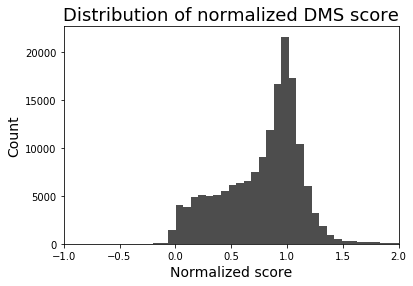

In [76]:
foo = dms_ascan[['score', 'dms_id', 'uniprot_id', 'u_pos', 'aa2']].dropna().drop_duplicates()
plt.figure(figsize=(6,4))
plt.hist(foo['score'], color=(0.3,0.3,0.3), bins=100)
plt.title('Distribution of normalized DMS score', fontsize=18)
plt.xlabel('Normalized score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(-1,2)
plt.show()

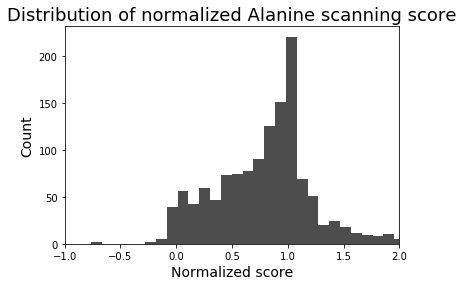

In [77]:
foo = dms_ascan[['AS_score', 'Ascan_id', 'uniprot_id', 'u_pos']].dropna().drop_duplicates()
plt.figure(figsize=(6,4))
plt.hist(foo['AS_score'], color=(0.3,0.3,0.3), bins=100)
plt.title('Distribution of normalized Alanine scanning score', fontsize=18)
plt.xlabel('Normalized score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(-1,2)
plt.show()

/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


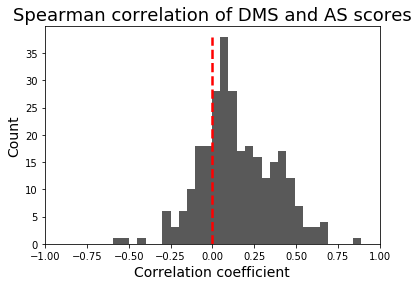

In [78]:
dmsa_corr = pd.Series()
for dmsa, df in dms_ascan.groupby('dmsa_id'):
    if dmsa[-3:] == 'nan':
        continue
    else:
        dmsa_corr[dmsa] = spearmanr(df['score'], df['AS_score'])[0]

plt.figure(figsize=(6,4))
plt.hist(dmsa_corr.dropna(), color=(0.35,0.35,0.35), bins=30)
plt.title('Spearman correlation of DMS and AS scores', fontsize=18)
plt.xlabel('Correlation coefficient', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(-1, 1)
plt.plot([0,0],[0,38],'--',c='red',linewidth=2.5)
plt.show()

In [79]:
dmsa_corr.median()

0.12549717539634703

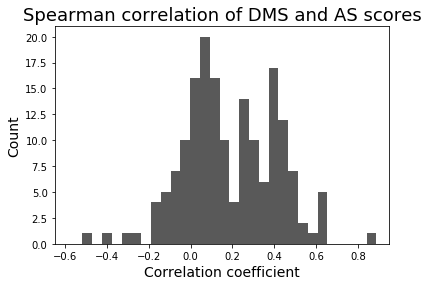

In [80]:
dmsa_corr = pd.Series()
for dmsa, df in dms_ascan.groupby('dmsa_id'):
    if dmsa[-3:] == 'nan' or dmsa[:4]=='ccr5':
        continue
    else:
        dmsa_corr[dmsa] = spearmanr(df['score'], df['AS_score'])[0]

plt.figure(figsize=(6,4))
plt.hist(dmsa_corr.dropna(), bins=30, color=(0.35,0.35,0.35))
plt.title('Spearman correlation of DMS and AS scores', fontsize=18)
plt.xlabel('Correlation coefficient', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(-0.65, 0.95)
plt.show()

## Feature completeness

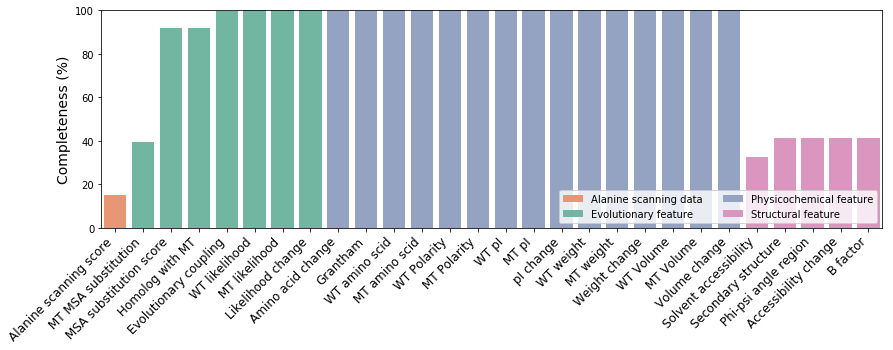

In [20]:
ava_variant = dms_ascan[dms_ascan['Ascan_score_avail']].groupby(['dms_id', 'position', 'aa2'], as_index=False).first()
ava_variant = ava_variant[['dms_id', 'position', 'aa2', 'AS_score']]

all_features = pd.merge(dms_feature_data, ava_variant, on=['dms_id', 'position', 'aa2'], how='left')
all_features = all_features[[x for x in all_features.columns if x in feature_info.index]]
feature_complete = ((~all_features.isna()).sum() / len(all_features) * 100).to_frame(name='completeness')
feature_complete = pd.concat([feature_info[['type', 'feature_name']], feature_complete], axis=1, 
                             sort=False).dropna().sort_values(['type', 'completeness'])

palette = {'Evolutionary feature': (0.4, 0.7607843137254902, 0.6470588235294118),
           'Alanine scanning data': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
           'Physicochemical feature': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
           'Structural feature': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)}

plt.figure(figsize=(14,4))
sns.barplot(x="feature_name", y="completeness", hue="type", data=feature_complete, dodge=False, 
            palette=palette).legend_.remove()
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylabel('Completeness (%)', fontsize=14)
plt.xlabel('', fontsize=14)
plt.legend(ncol=2, loc=4)
plt.ylim(0, 100)
plt.show()

## Feature correlation

In [95]:
dms_feature = dms_ascan[basic_features + ['dms_id', 'uniprot_id', 'score', 'aa2', 'u_pos']].drop_duplicates().sort_values('uniprot_id')
dms_feature['dms_name'] = dms_feature['dms_id'].map(data_info.groupby('dms_id').first()['dms_name'])
feature_corr = ana.calculate_score_feature_correlation(dms_feature, basic_features, 'score', 'dms_name')

/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/fu.j/.conda/envs/Python3-recover/li

In [96]:
feature_corr

,delta_psic,aa1_psic,Grantham,aa1_polarity_Hydrophobic,dssp_sec_str_E,aa2_P,phi_psi_reg_B,aa1_C,aa1_polarity_Special,aa1_Y,...,aa1_polarity_negativeCharge,dssp_sec_str_B,phi_psi_reg_A,aa1_polarity_Polar,b_factor,accessibility,mut_msa_congruency,aa2_psic,evolutionary_coupling_avg,phi_psi_reg_P
ACE2-s-high,-0.227780,-0.181034,-0.147964,-0.100879,-0.188952,-0.124030,-0.105053,NaN,-0.135630,-0.071253,...,-0.035628,NaN,0.098381,0.205927,0.152543,0.290444,0.210509,0.189112,0.104161,NaN
AICDA-G3,-0.266664,-0.272229,-0.267712,-0.263530,NaN,-0.067995,NaN,-0.205658,-0.089341,-0.329797,...,0.126074,NaN,NaN,NaN,NaN,NaN,0.215442,0.166934,0.347929,NaN
Abeta42,0.051953,-0.116856,0.066013,-0.524257,NaN,-0.182190,NaN,NaN,0.245786,-0.096008,...,0.277049,NaN,NaN,0.151994,NaN,NaN,-0.078793,-0.134700,-0.042496,NaN
BRCA1_E3,-0.238542,-0.252734,-0.135723,0.000653,NaN,-0.017127,NaN,-0.160542,-0.085981,0.022775,...,-0.043510,NaN,NaN,0.082390,NaN,NaN,0.059593,0.152014,-0.021377,NaN
BRCA1_E3-Envision,-0.207672,-0.131851,-0.121981,-0.001731,NaN,-0.038499,NaN,-0.116011,-0.068893,-0.012760,...,-0.041057,NaN,NaN,0.048987,NaN,NaN,0.104190,0.177658,-0.072715,NaN
BRCA1_Findlay,-0.462352,-0.421670,-0.218229,-0.110018,-0.096495,-0.104757,0.019513,-0.186272,-0.139048,-0.008089,...,0.038833,-0.048161,-0.033050,0.121672,0.201166,0.166357,0.246838,0.367137,-0.027368,NaN
BRCA1_Starita_2018,-0.129419,-0.114619,-0.101277,-0.078286,NaN,-0.025874,NaN,-0.209281,-0.088925,0.013968,...,0.016212,NaN,NaN,0.058150,NaN,NaN,-0.013113,0.089166,-0.055183,NaN
BRCA1_Y2H,-0.008652,-0.126747,-0.021950,-0.102278,NaN,-0.069274,NaN,-0.199535,-0.099417,-0.042155,...,0.049616,NaN,NaN,0.070928,NaN,NaN,-0.040765,-0.053095,0.006703,NaN
BRCA1_Y2H-Envision,-0.098699,-0.116721,-0.181207,0.001234,NaN,-0.044814,NaN,-0.317023,-0.239516,-0.053590,...,-0.002441,NaN,NaN,0.036868,NaN,NaN,-0.017507,0.062423,0.066542,NaN
CBS_High-B6,-0.463630,-0.453614,-0.183603,-0.112072,-0.110793,-0.052470,-0.085817,-0.043031,-0.057467,-0.071741,...,0.041458,-0.036918,0.141433,0.089622,0.114040,0.273503,0.389498,0.338060,0.342532,NaN


In [97]:
feature_corr.median()

delta_psic                    -0.278444
aa1_psic                      -0.272229
Grantham                      -0.149612
aa1_polarity_Hydrophobic      -0.145403
dssp_sec_str_E                -0.118476
aa2_P                         -0.109418
phi_psi_reg_B                 -0.081971
aa1_C                         -0.071024
aa1_polarity_Special          -0.065388
aa1_Y                         -0.065097
delta_solvent_accessibility   -0.064063
aa2_polarity_negativeCharge   -0.056977
aa1_F                         -0.054957
aa1_I                         -0.053417
aa2_polarity_Special          -0.050651
aa1_W                         -0.044411
wt_mut_LP                     -0.042654
wt_mut_YP                     -0.039296
wt_mut_FP                     -0.038755
wt_mut_IP                     -0.037346
aa1_L                         -0.036498
wt_mut_VD                     -0.036306
wt_mut_LD                     -0.036022
wt_mut_LR                     -0.035741
wt_mut_LK                     -0.034858


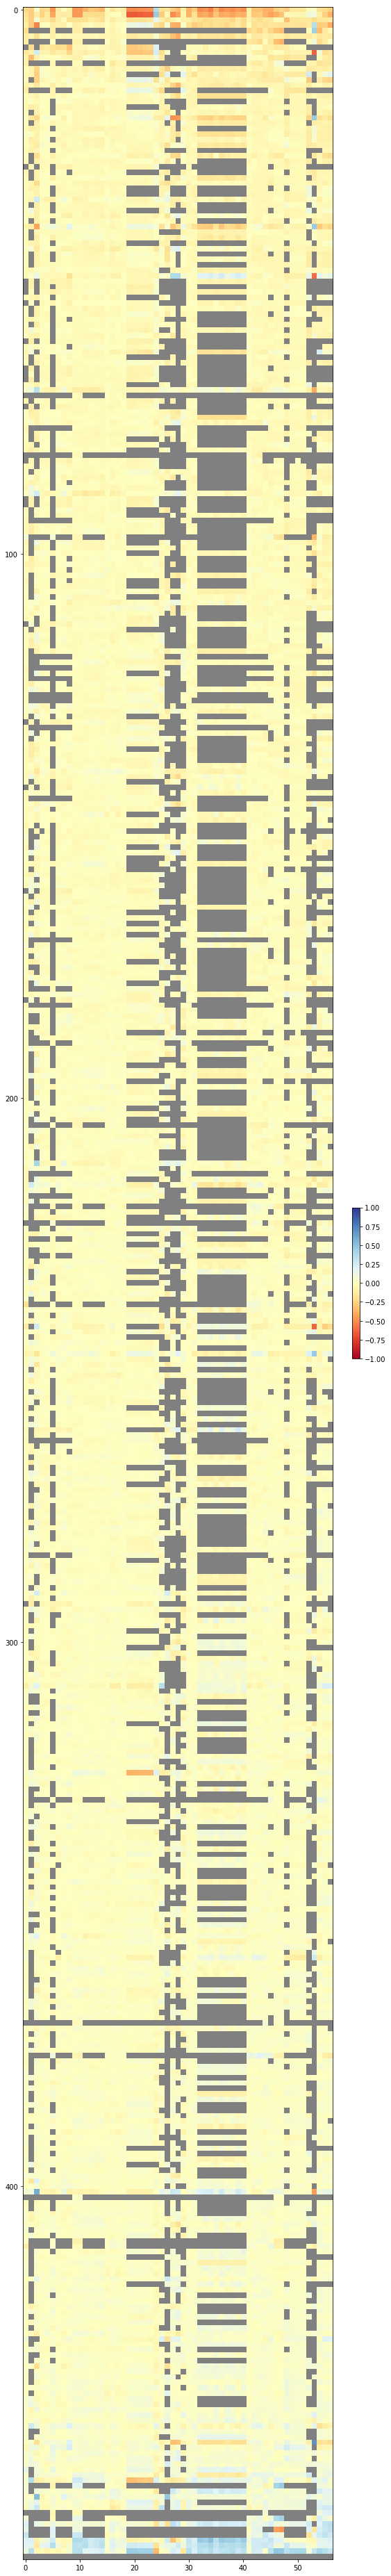

In [98]:
fig, ax = plt.subplots(1,1,figsize=(10,80))
im = figs.par.create_score_heatmap_on_axes(ax, feature_corr.T, vcenter=0, vmin=-1, vmax=1, cmap='RdYlBu')
plt.colorbar(im, ax=ax,shrink=0.05)
plt.show()

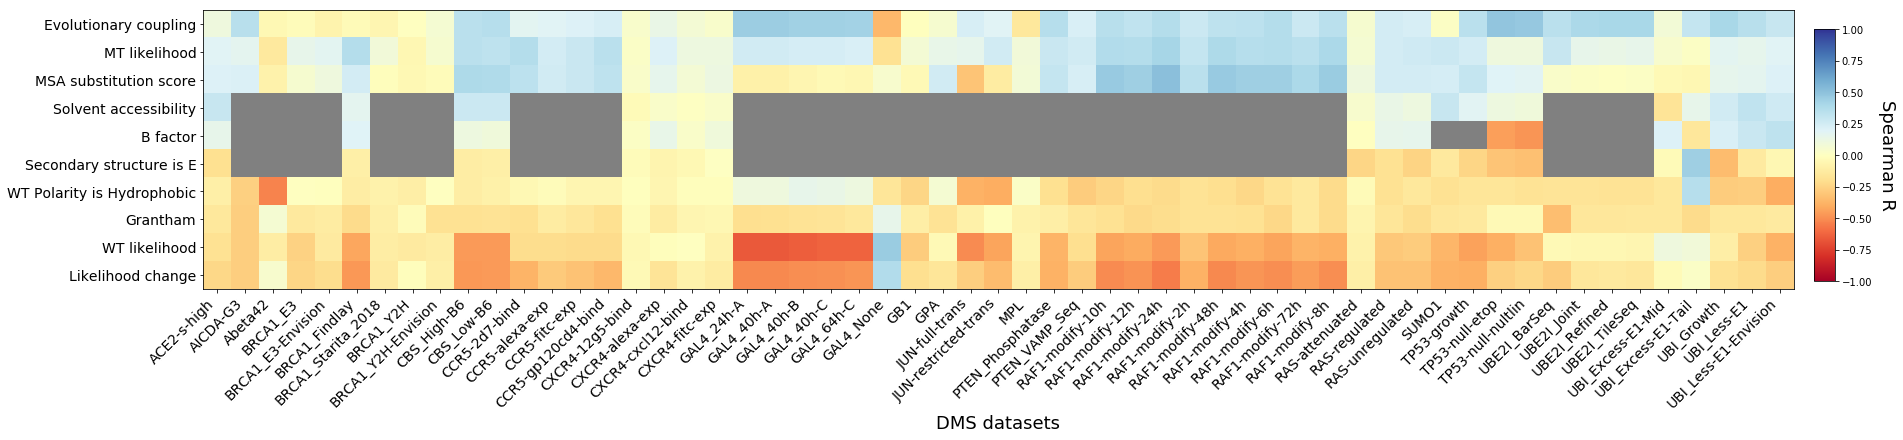

In [195]:
correlated = list(feature_corr.columns[:5]) + list(feature_corr.columns[-6:-1])
correlated.reverse()
vis_data = feature_corr[correlated]
cor_name = feature_info['feature_name'][correlated].values

fig, ax = plt.subplots(1,1,figsize=(28.5, 10))
im = figs.par.create_score_heatmap_on_axes(ax, vis_data.T, vcenter=0, vmin=-1, vmax=1, cmap='RdYlBu')
cbaxes = fig.add_axes([0.91, 0.32, 0.01, 0.35]) 
cbar = plt.colorbar(im, ax=ax, shrink=0.5, cax = cbaxes)
cbar.ax.set_ylabel('Spearman R', fontsize=18, rotation=270)
cbar.ax.yaxis.set_label_coords(4, 0.5)
ax.set_yticks(np.arange(len(cor_name)))
ax.set_yticklabels(labels=cor_name, fontsize=14)
ax.set_xticks(np.arange(len(vis_data)))
ax.set_xticklabels(vis_data.index, fontsize=14, rotation=45, ha='right')
ax.set_xlabel('DMS datasets', fontsize=18)
plt.show()

In [196]:
correlated

['evolutionary_coupling_avg',
 'aa2_psic',
 'mut_msa_congruency',
 'accessibility',
 'b_factor',
 'dssp_sec_str_E',
 'aa1_polarity_Hydrophobic',
 'Grantham',
 'aa1_psic',
 'delta_psic']

In [101]:
ascan_feature = dms_ascan[basic_features + ['Ascan_id', 'uniprot_id', 'AS_score', 'aa2', 'u_pos']].dropna().sort_values('uniprot_id')
ascan_feat_corr = ana.calculate_score_feature_correlation(ascan_feature, basic_features, 'AS_score', 'Ascan_id')

/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/Python3-recover/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/fu.j/.conda/envs/Python3-recover/li

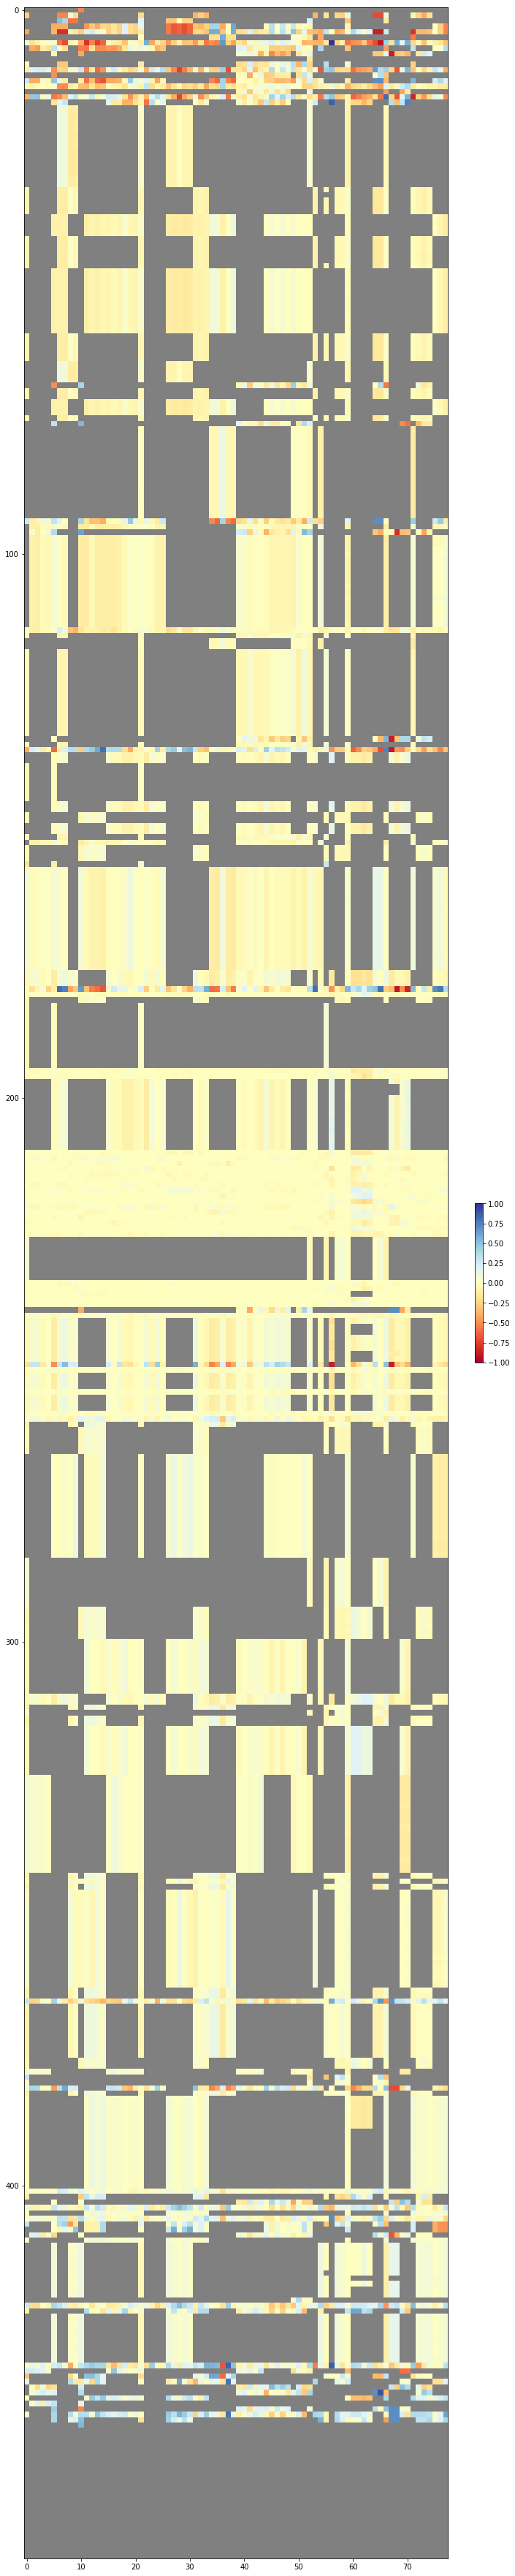

In [102]:
fig, ax = plt.subplots(1,1,figsize=(13,80))
im = figs.par.create_score_heatmap_on_axes(ax, ascan_feat_corr.T, vcenter=0, vmin=-1, vmax=1, cmap='RdYlBu')
plt.colorbar(im, ax=ax,shrink=0.05)
plt.show()

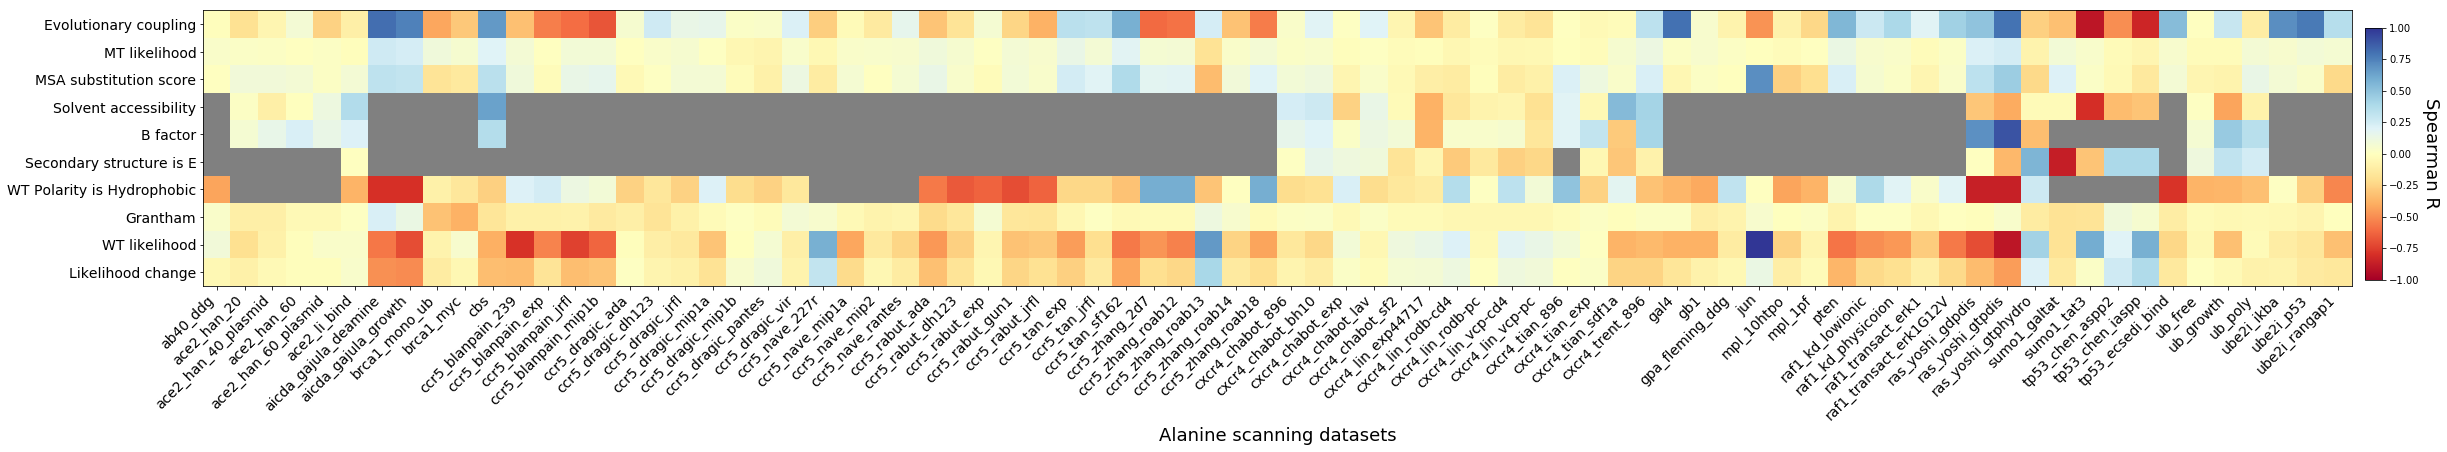

In [207]:
selected = ['evolutionary_coupling_avg', 'aa2_psic', 'mut_msa_congruency', 'accessibility', 'b_factor', 
            'dssp_sec_str_E', 'aa1_polarity_Hydrophobic', 'Grantham', 'aa1_psic', 'delta_psic']
vis_data = filtered_ascan_corr[selected]
cor_name = feature_info['feature_name'][selected].values

fig, ax = plt.subplots(1,1,figsize=(38.5, 10))
im = figs.par.create_score_heatmap_on_axes(ax, vis_data.T, vcenter=0, vmin=-1, vmax=1, cmap='RdYlBu')
cbaxes = fig.add_axes([0.905, 0.32, 0.006, 0.35]) 
cbar = plt.colorbar(im, ax=ax, shrink=0.5, cax = cbaxes)
cbar.ax.set_ylabel('Spearman R', fontsize=18, rotation=270)
cbar.ax.yaxis.set_label_coords(4.5, 0.5)
ax.set_yticks(np.arange(len(cor_name)))
ax.set_yticklabels(labels=cor_name, fontsize=14)
ax.set_xticks(np.arange(len(vis_data)))
ax.set_xticklabels(vis_data.index, fontsize=14, rotation=45, ha='right')
ax.set_xlabel('Alanine scanning datasets', fontsize=18)
plt.show()

In [204]:
filtered_ascan_corr = ascan_feat_corr.loc[:, ascan_feat_corr.isna().sum() <= 0.75*len(ascan_feat_corr)]
filtered_ascan_corr = filtered_ascan_corr[filtered_ascan_corr.median().sort_values().index]

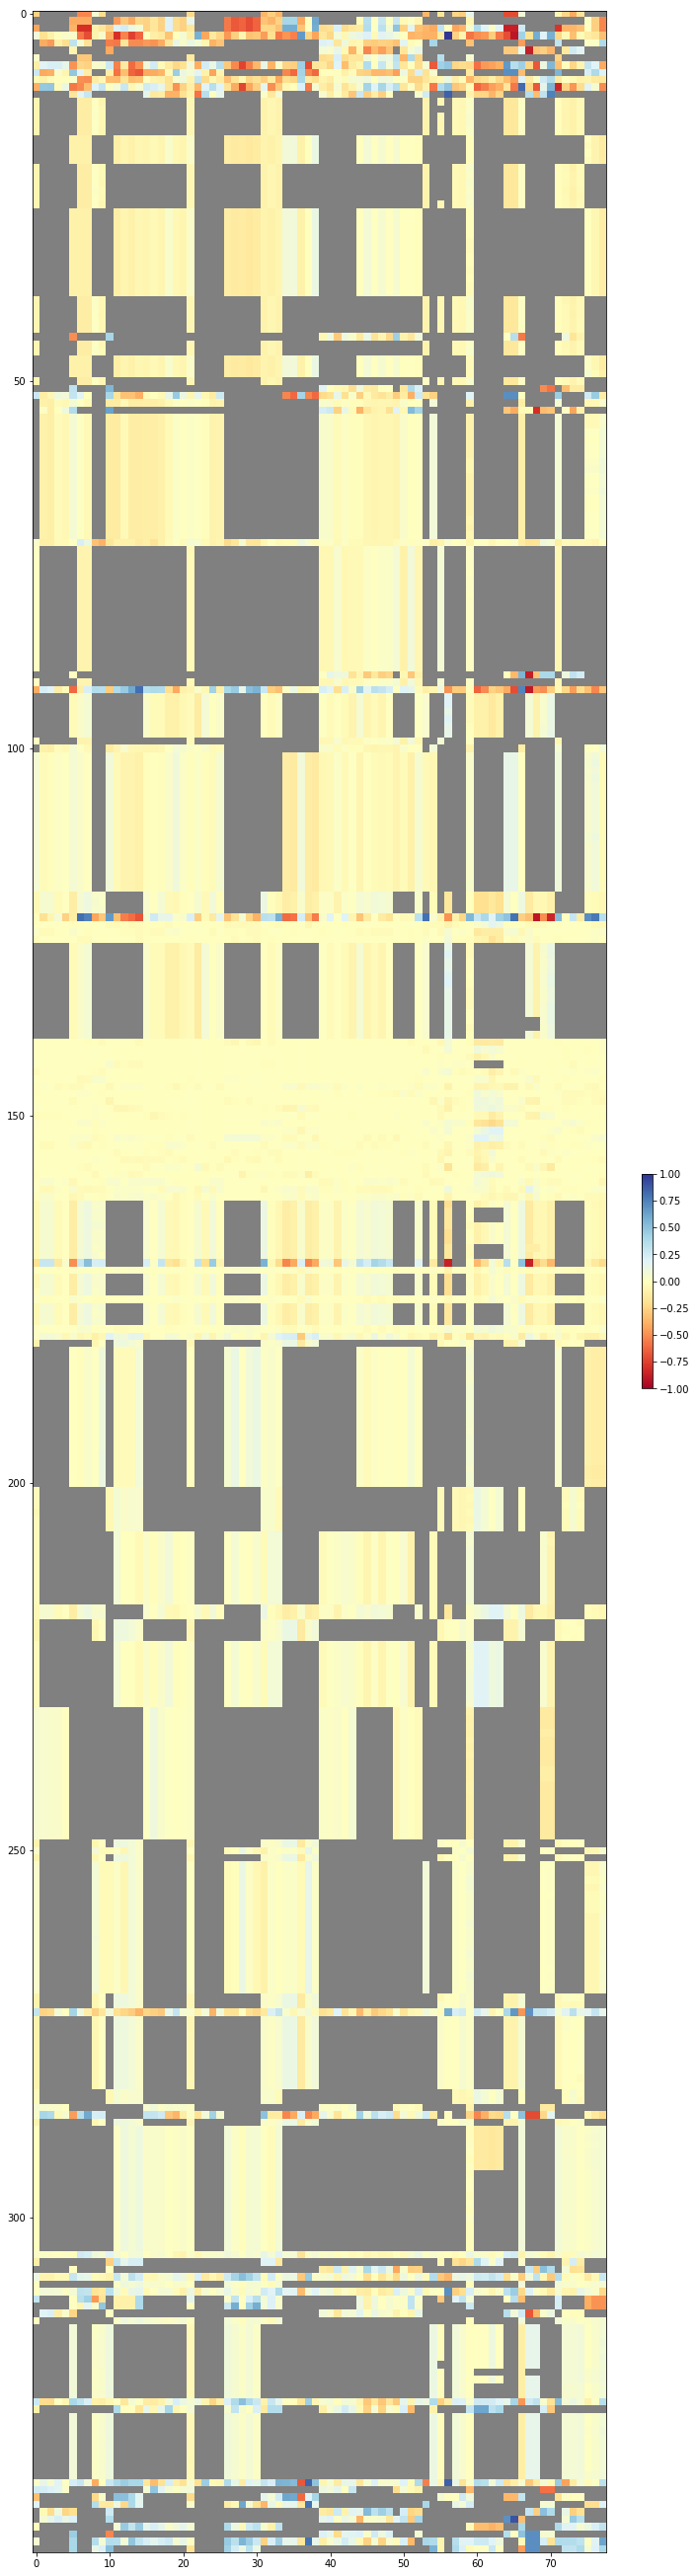

In [205]:
fig, ax = plt.subplots(1,1,figsize=(13,80))
im = figs.par.create_score_heatmap_on_axes(ax, filtered_ascan_corr.T, vcenter=0, vmin=-1, vmax=1, cmap='RdYlBu')
plt.colorbar(im, ax=ax,shrink=0.05)
plt.show()

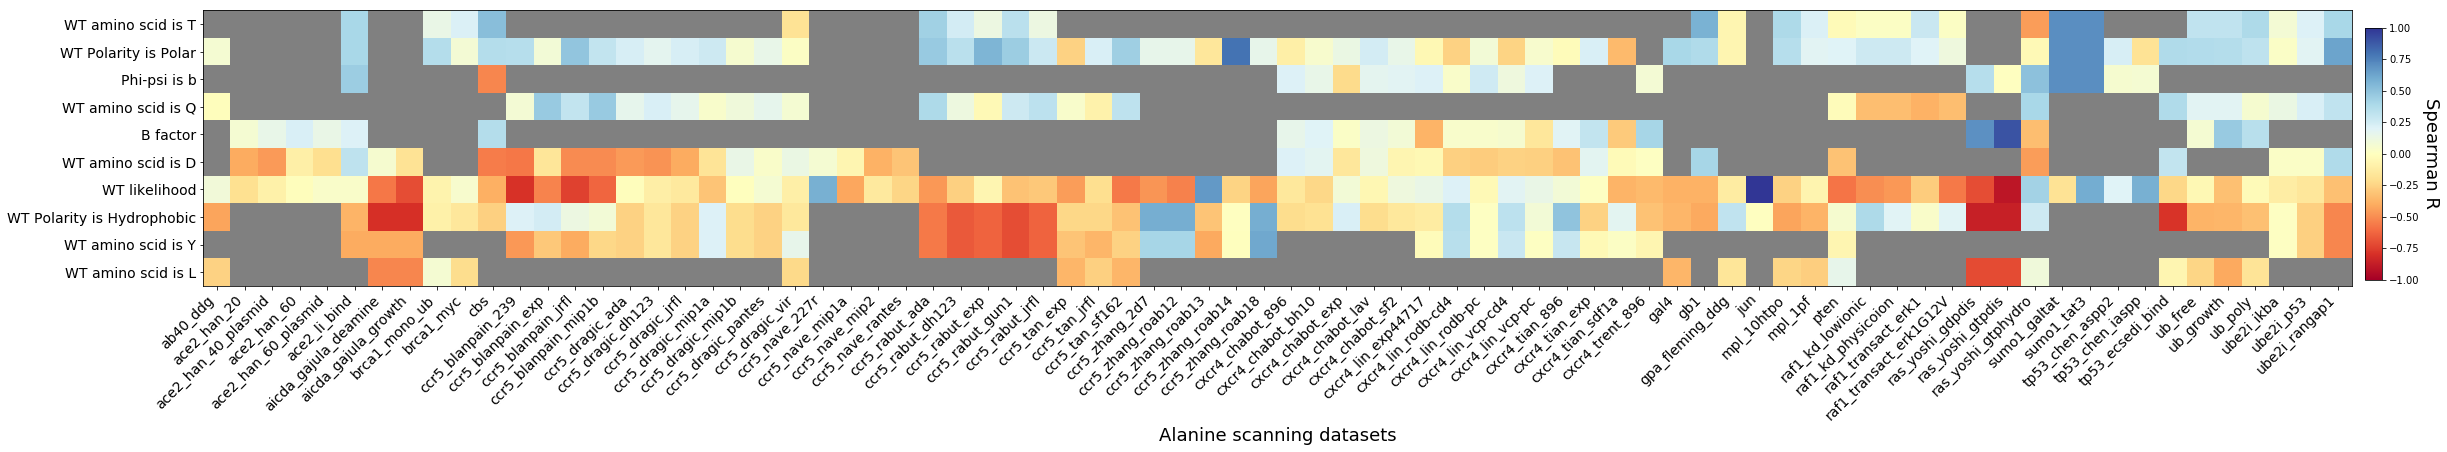

In [206]:
correlated = list(filtered_ascan_corr.columns[:5]) + list(filtered_ascan_corr.columns[-5:])
correlated.reverse()
vis_data = filtered_ascan_corr[correlated]
cor_name = feature_info['feature_name'][correlated].values

fig, ax = plt.subplots(1,1,figsize=(38.5, 10))
im = figs.par.create_score_heatmap_on_axes(ax, vis_data.T, vcenter=0, vmin=-1, vmax=1, cmap='RdYlBu')
cbaxes = fig.add_axes([0.905, 0.32, 0.006, 0.35]) 
cbar = plt.colorbar(im, ax=ax, shrink=0.5, cax = cbaxes)
cbar.ax.set_ylabel('Spearman R', fontsize=18, rotation=270)
cbar.ax.yaxis.set_label_coords(4.5, 0.5)
ax.set_yticks(np.arange(len(cor_name)))
ax.set_yticklabels(labels=cor_name, fontsize=14)
ax.set_xticks(np.arange(len(vis_data)))
ax.set_xticklabels(vis_data.index, fontsize=14, rotation=45, ha='right')
ax.set_xlabel('Alanine scanning datasets', fontsize=18)
plt.show()

# Results with alanine scanning data available mutants

## Result reading

In [110]:
mut_prediction = ana.combine_prediction_result(result_dir_available)
mut_prediction = pd.merge(mut_prediction, data_info, on='dmsa_id', how='left', validate='m:1')
model_perform = ana.calculate_model_performance(mut_prediction)

In [21]:
importance_with_as = ana.read_feature_importance(result_dir_available, 
                                                 basic_features+['AS_score', 'Ascan_score_avail'], 
                                                 'with_ala')
importance_without_as = ana.read_feature_importance(result_dir_available, basic_features, 'nothing')

## Overall performance

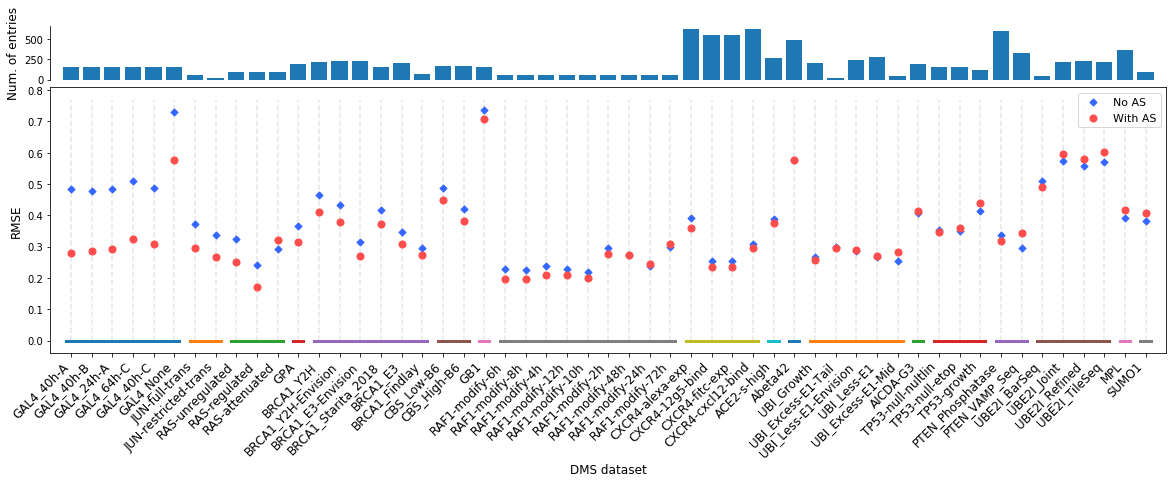

In [158]:
fig = figs.median_dms_performance_scatterplot(model_perform)
plt.show()

In [113]:
med_dmsas = figs.par.pick_sort_med_rmse_diff(model_perform)
med_dmsas['diff_rmse'].describe()

count    53.000000
mean      0.034227
std       0.061221
min      -0.047678
25%      -0.003391
50%       0.019834
75%       0.045395
max       0.204443
Name: diff_rmse, dtype: float64

In [114]:
med_dmsas[med_dmsas['protein_name'] == 'GAL4'][['ala_rmse', 'noala_rmse', 'dms_id', 'Ascan_id']].mean()

ala_rmse      0.345392
noala_rmse    0.528477
dtype: float64

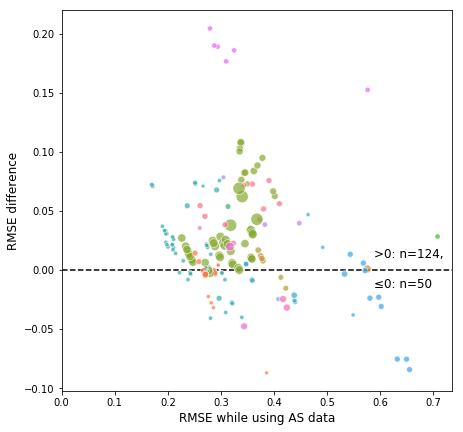

In [159]:
work_data = model_perform.copy()
work_data.rename(columns={'protein_name':'Protein name', 'size':'Size (≥)'}, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(7,7))
g = sns.scatterplot(data=work_data, x='ala_rmse', y='diff_rmse', size='Size (≥)', hue='Protein name', 
                    alpha=0.7, ax=ax, sizes=(15,150), 
                    palette=sns.color_palette("husl", n_colors=len(work_data['uniprot_id'].unique())))
g.legend_.remove()
xlim = ax.get_xlim()
ax.plot([0, xlim[1]], [0, 0], '--', c='k', zorder=0)
ax.text(0.8 * xlim[1], 
        -0.015, 
        f">0: n={sum(work_data['diff_rmse']>0)},\n\n≤0: n={sum(work_data['diff_rmse']<=0)}", 
        fontsize=12)

ax.set_xlim([0, xlim[1]])
ax.set_xlabel('RMSE while using AS data', fontsize=12)
ax.set_ylabel('RMSE difference', fontsize=12)
plt.show()

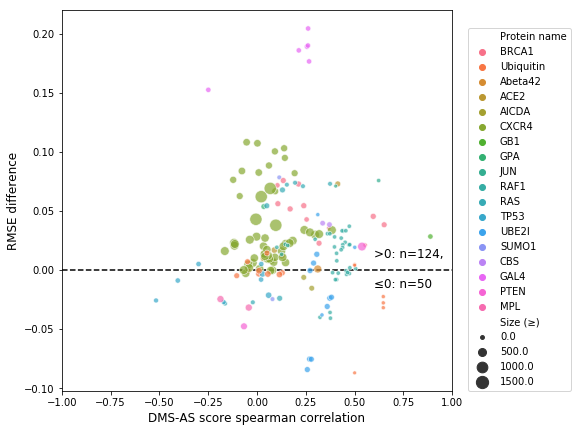

In [178]:
dmsa_corr = pd.Series(name='dmsa_corr')
for dmsa, df in dms_ascan.groupby('dmsa_id'):
    if dmsa[-3:] == 'nan':
        continue
    else:
        dmsa_corr[dmsa] = spearmanr(df['score'], df['AS_score'])[0]
# All AS scores are the same will cause NA value, which should be 0.5 according to the formula.
dmsa_corr = dmsa_corr.fillna(0.5)
work_data = pd.merge(model_perform, dmsa_corr, how='inner', left_on='dmsa_id', right_index=True)
work_data.rename(columns={'protein_name':'Protein name', 'size':'Size (≥)'}, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(7,7))
g = sns.scatterplot(data=work_data, x='dmsa_corr', y='diff_rmse', size='Size (≥)', hue='Protein name', 
                    alpha=0.7, ax=ax, sizes=(15,150), 
                    palette=sns.color_palette("husl", n_colors=len(work_data['uniprot_id'].unique())))
ax.plot([-1, 1], [0, 0], '--', c='k', zorder=0)
ax.text(0.6, -0.015, f">0: n={sum(work_data['diff_rmse']>0)},\n\n≤0: n={sum(work_data['diff_rmse']<=0)}", 
        fontsize=12)
ax.set_xlim(-1, 1)
ax.set_xlabel('DMS-AS score spearman correlation', fontsize=12)
ax.set_ylabel('RMSE difference', fontsize=12)
plt.legend(loc=(1.04, 0))
plt.show()

## Mutational heatmap

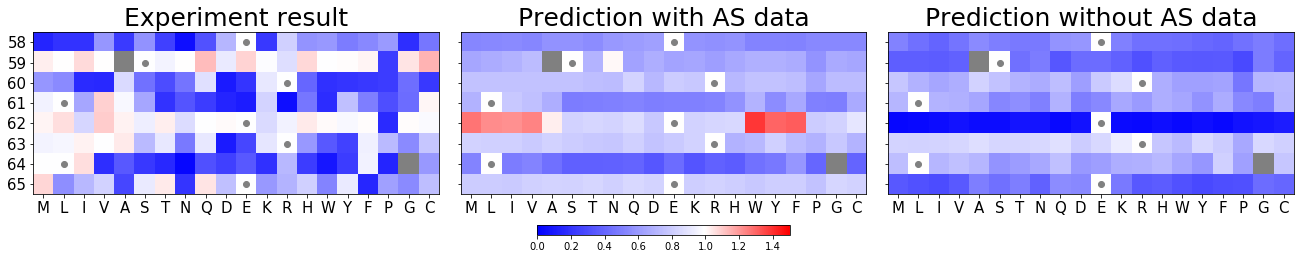

In [48]:
work_data = mut_prediction[mut_prediction['dmsa_id'] == 'urn:mavedb:00000012-a-5@gal4']
work_data = pd.merge(work_data, dms_ascan[['dmsa_id', 'position', 'aa2', 'pos_id', 'aa1', 'u_pos']], 
                     how='left', on=['dmsa_id', 'position', 'aa2'], suffixes=['', '_merge'])
# Data for S59A and L64G were explicitly added during predictor evaluation process.
fig = figs.prediction_heatmap(work_data)
plt.show()

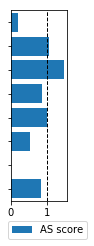

In [37]:
work_data = dms_ascan[dms_ascan['dmsa_id'] == 'urn:mavedb:00000012-a-5@gal4'][['u_pos', 'AS_score']].drop_duplicates()

fig, ax = plt.subplots(1, 1, figsize=(1, 3.5))
ax.barh(np.arange(len(work_data)), work_data.sort_values('u_pos', ascending=False)['AS_score'], 
        zorder=-1, label='AS score')
ax.plot([1, 1], [-0.5, len(work_data) - 0.5], '--', color='black', linewidth=1)
ax.set_ylim(-0.5, 7.5)
ax.set_yticklabels([])
ax.legend(loc=[-0.05,-0.2])
plt.show()

## Amino acid bias

### Prediction accuracy bias

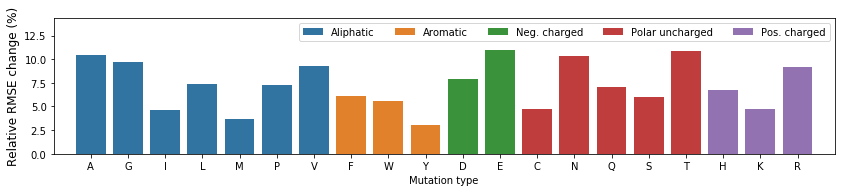

In [182]:
fig = figs.mutation_type_bias_barplot(mut_prediction)
plt.show()

In [217]:
wt_comp = figs.par.calc_aa_type_rmse(mut_prediction, 'aa2')
wt_comp['ratio'] = (wt_comp['noala_rmse'] - wt_comp['ala_rmse']) / wt_comp['noala_rmse'] * 100
print(wt_comp['ratio'].mean())
wt_comp.sort_values('ratio')

7.282054373567171


,aa,ala_rmse,noala_rmse,aa_property,ratio
19,Y,0.348795,0.359822,Aromatic,3.064585
10,M,0.342971,0.356132,Aliphatic,3.695316
7,I,0.365585,0.383452,Aliphatic,4.659353
8,K,0.362563,0.380691,Pos. charged,4.761883
1,C,0.401693,0.421840,Polar uncharged,4.775878
18,W,0.346853,0.367432,Aromatic,5.600838
15,S,0.352507,0.374873,Polar uncharged,5.966324
4,F,0.332776,0.354398,Aromatic,6.101092
6,H,0.370194,0.396806,Pos. charged,6.706501
13,Q,0.351811,0.378472,Polar uncharged,7.044323


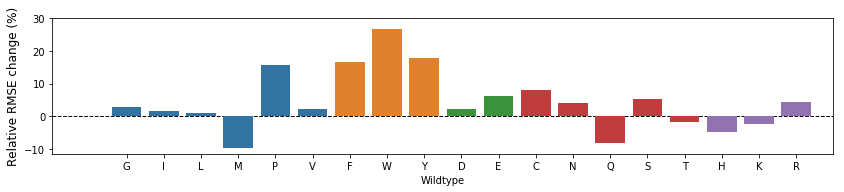

In [186]:
work_data = pd.merge(mut_prediction, dms_ascan[['dmsa_id', 'position', 'aa2', 'aa1']], 
                     how='left', on=['dmsa_id', 'position', 'aa2'], suffixes=['', '_merge'])
fig = figs.wildtype_bias_barplot(work_data)
plt.show()

In [120]:
work_data = pd.merge(mut_prediction, dms_ascan[['dmsa_id', 'position', 'aa2', 'aa1']], 
                     how='left', on=['dmsa_id', 'position', 'aa2'], suffixes=['', '_merge'])
wt_comp = figs.par.calc_aa_type_rmse(work_data, 'aa1')
wt_comp['ratio'] = (wt_comp['noala_rmse'] - wt_comp['ala_rmse']) / wt_comp['noala_rmse'] * 100
wt_comp[wt_comp['aa_property'] == 'Aromatic'][['aa', 'ratio']]

,aa,ratio
3,F,16.460069
17,W,26.778751
18,Y,17.932601


### Count bias

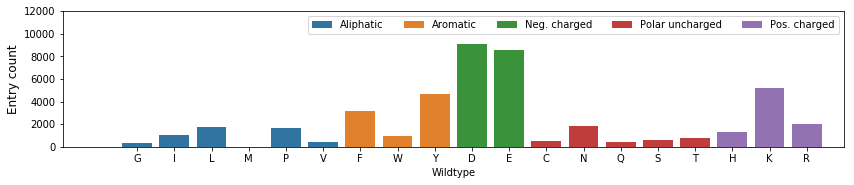

In [42]:
work_data = pd.merge(mut_prediction, dms_ascan[['dmsa_id', 'position', 'aa2', 'aa1']], 
                     how='left', on=['dmsa_id', 'position', 'aa2'], suffixes=['', '_merge'])
count_data = work_data.groupby('aa1', as_index=False).count()[['ob_score', 'aa1']]
count_data['aa_property'] = count_data['aa1'].map(figs.par.AA_PROPERTY)
count_data.sort_values(['aa_property', 'aa1'], inplace=True)

fig = plt.figure(figsize=(14, 2.5))
sns.barplot(x="aa1", y="ob_score", hue="aa_property", data=count_data, dodge=False)
plt.xticks(ticks=np.arange(19), label=count_data['aa1'])
plt.xlabel('Wildtype')
plt.ylabel('Entry count', fontsize=12)
plt.xlim(-2, 19)
plt.ylim(0, 12000)
plt.legend(loc=1, ncol=5)
plt.show()

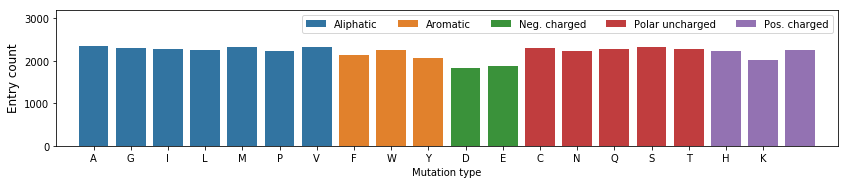

In [43]:
count_data = mut_prediction.groupby('aa2', as_index=False).count()[['ob_score', 'aa2']]
count_data['aa_property'] = count_data['aa2'].map(figs.par.AA_PROPERTY)
count_data.sort_values(['aa_property', 'aa2'], inplace=True)

fig = plt.figure(figsize=(14, 2.5))
sns.barplot(x="aa2", y="ob_score", hue="aa_property", data=count_data, dodge=False)
plt.xticks(ticks=np.arange(19), label=count_data['aa2'])
plt.xlabel('Mutation type')
plt.ylabel('Entry count', fontsize=12)
plt.xlim(-1, 20)
plt.ylim(0, 3200)
plt.legend(loc=1, ncol=5)
plt.show()

## AS data bias

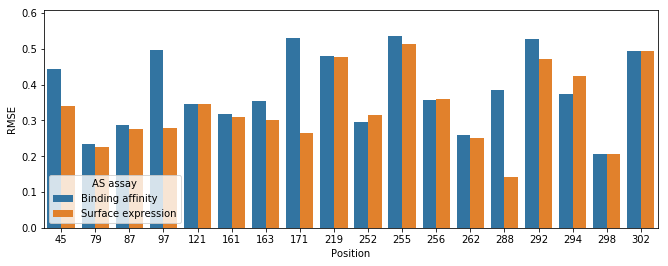

In [44]:
dms_as_pair = ['cxcr4-fitc-exp@cxcr4_tian_896', 'cxcr4-fitc-exp@cxcr4_tian_exp']
assay_info = dict(zip(dms_as_pair, ['Binding affinity', 'Surface expression']))
work_data = mut_prediction[mut_prediction['dmsa_id'].isin(dms_as_pair)]
work_data = pd.merge(work_data, dms_ascan[['dmsa_id', 'position', 'aa2', 'u_pos']], how='left', 
                     on=['dmsa_id', 'position', 'aa2'])
fig = figs.assay_error_barplot(work_data, dms_as_pair, assay_info)
plt.show()

## Feature importance

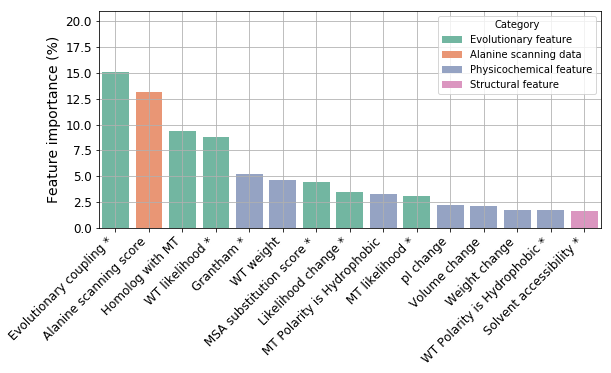

In [22]:
mean_importance = importance_with_as.median().sort_values(ascending=False)
imp_vis = mean_importance.head(15).to_frame()
imp_vis.columns = ['AS_imp']
imp_vis['Category'] = imp_vis.index.map(feature_info['type'])
correlated_feat = ['Evolutionary coupling', 'MT likelihood', 'MSA substitution score', 'Solvent accessibility',
                   'B factor', 'Secondary structure is E', 'WT Polarity is Hydrophobic', 'Grantham',
                   'WT likelihood', 'Likelihood change']

imp_vis.index = [x+' *' if x in correlated_feat else x for x in imp_vis.index.map(feature_info['feature_name'])]

palette = {'Evolutionary feature': (0.4, 0.7607843137254902, 0.6470588235294118),
           'Alanine scanning data': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
           'Physicochemical feature': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
           'Structural feature': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)}

plt.figure(figsize=(9, 4))
g = sns.barplot(x=imp_vis.index, y=imp_vis['AS_imp']*100, hue=imp_vis['Category'], data=imp_vis, 
                dodge=False, palette=palette)
plt.xticks(ticks=np.arange(15), labels=imp_vis.index, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.ylabel('Feature importance (%)', fontsize=14)
plt.ylim(0,21)
plt.show()

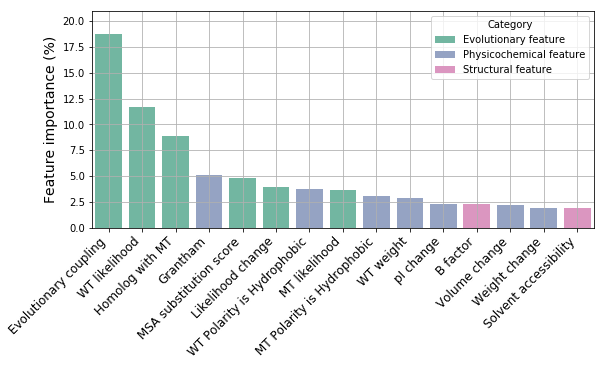

In [23]:
mean_importance = importance_without_as.median().sort_values(ascending=False)
imp_vis = mean_importance.head(15).to_frame()
imp_vis.columns = ['AS_imp']
imp_vis['Category'] = imp_vis.index.map(feature_info['type'])
imp_vis.index = imp_vis.index.map(feature_info['feature_name'])

palette = {'Evolutionary feature': (0.4, 0.7607843137254902, 0.6470588235294118),
           'Alanine scanning data': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
           'Physicochemical feature': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
           'Structural feature': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)}

plt.figure(figsize=(9,4))
g = sns.barplot(imp_vis.index, imp_vis['AS_imp']*100, imp_vis['Category'], data=imp_vis, 
                dodge=False, palette=palette)
plt.xticks(ticks=np.arange(15), labels=imp_vis.index, rotation=45, ha='right', fontsize=12)
plt.ylabel('Feature importance (%)', fontsize=14)
plt.ylim(0,21)
plt.grid()
plt.show()

## ROC analysis

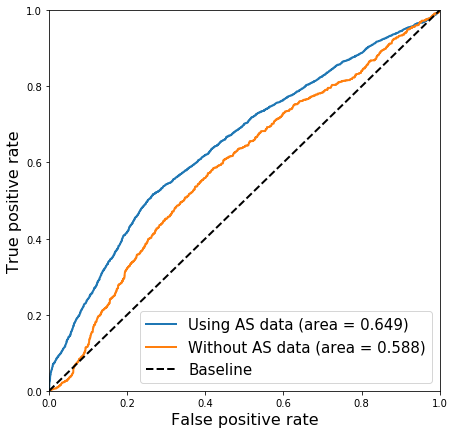

In [189]:
if_not_loss = mut_prediction['ob_score'] <= 0.35
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
figs.plot_roc_curve_on_axes(ax, ['Using AS data', 'Without AS data'], 
                            [if_not_loss, -mut_prediction['pred_score_ala']], 
                            [if_not_loss, -mut_prediction['pred_score_noala']])
ax.set_xlabel('False positive rate', fontsize=16)
ax.set_ylabel('True positive rate', fontsize=16)
ax.legend(loc="lower right", fontsize=15)
plt.show()

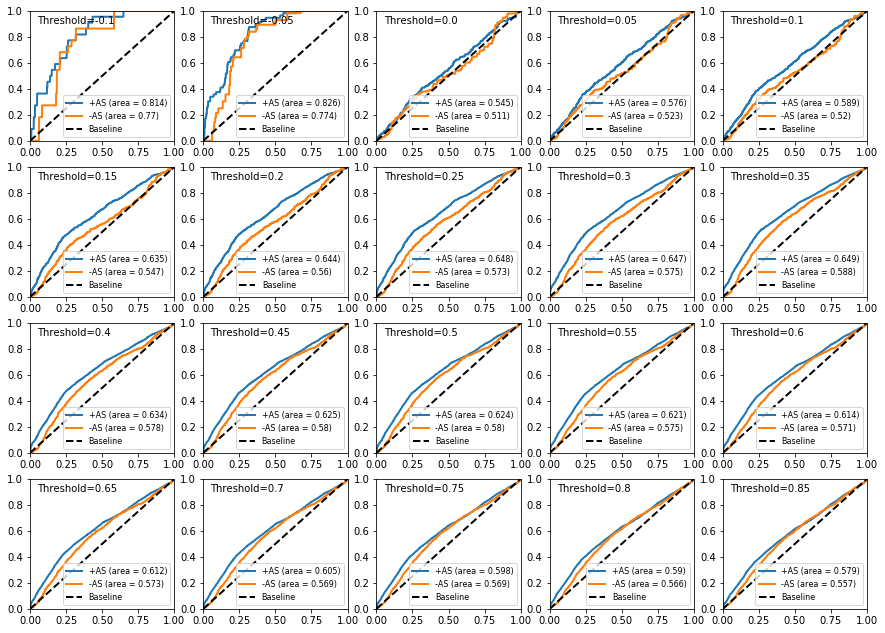

In [188]:
fig, axs = plt.subplots(4, 5, figsize=(15, 11))
axs = axs.reshape(-1)
for i, threshold in enumerate(np.arange(-0.1, 0.9, 0.05)):
    threshold = np.round(threshold, 2)
    if_not_loss = mut_prediction['ob_score'] <= threshold
    figs.plot_roc_curve_on_axes(axs[i], ['+AS', '-AS'], 
                                [if_not_loss, -mut_prediction['pred_score_ala']], 
                                [if_not_loss, -mut_prediction['pred_score_noala']])
    axs[i].text(0.05, 0.9, f"Threshold={threshold}")
    axs[i].legend(loc="lower right", fontsize=8)
plt.show()

## Structural bias

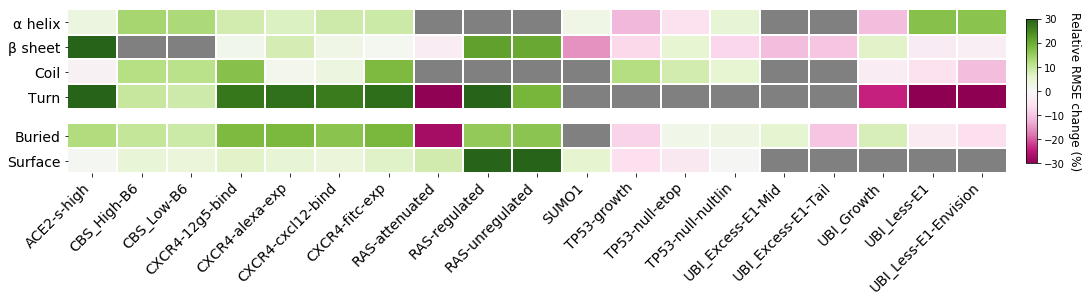

In [150]:
structure_data = dms_feature_data.loc[:, ['dms_id', 'position', 'aa1', 'dssp_sec_str', 'accessibility']]
structure_data['is_surface'] = structure_data['accessibility'] > 0.2
fig = figs.protein_structure_bias_heatmap(structure_data, mut_prediction, (-30, 30))
plt.show()

# Results with all mutants

## Result reading

In [61]:
mut_prediction = ana.combine_prediction_result(result_dir_all)
mut_prediction = pd.merge(mut_prediction, data_info, on='dmsa_id', how='left', validate='m:1')
model_perform = ana.calculate_model_performance(mut_prediction)

In [62]:
importance_with_as = ana.read_feature_importance(result_dir_all, 
                                                 basic_features+['AS_score', 'Ascan_score_avail'], 
                                                 'with_ala')
importance_without_as = ana.read_feature_importance(result_dir_all, basic_features, 'nothing')

## Overall performance

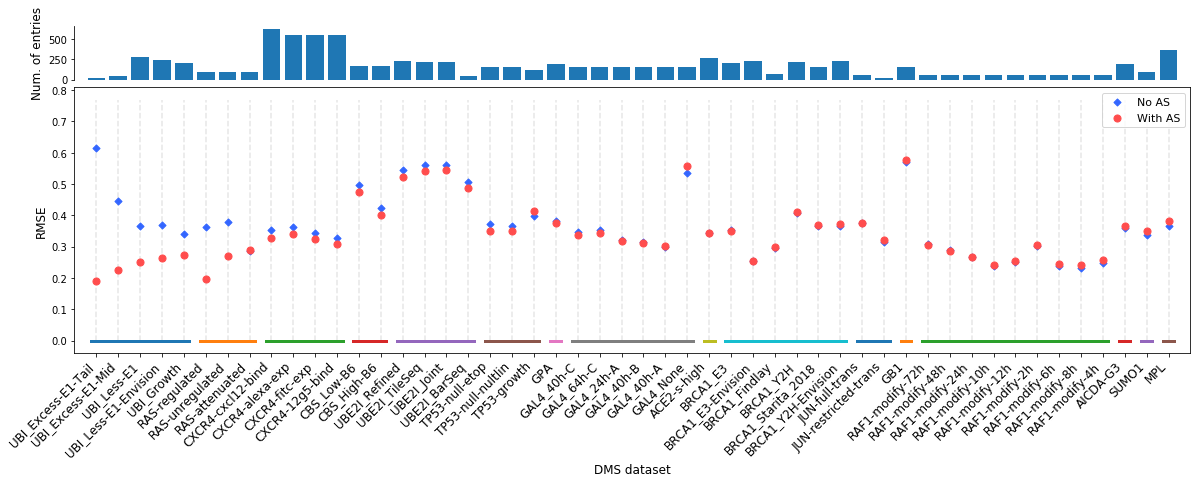

In [29]:
ava_data = model_perform.dropna()  # Datasets with available AS data
fig = figs.median_dms_performance_scatterplot(ava_data)
plt.show()

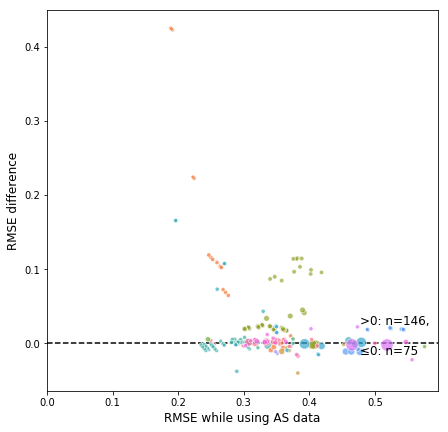

In [30]:
work_data = model_perform.copy()
work_data.rename(columns={'protein_name':'Protein name', 'size':'Size (≥)'}, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(7,7))
g = sns.scatterplot(data=work_data, x='ala_rmse', y='diff_rmse', size='Size (≥)', hue='Protein name', 
                    alpha=0.7, ax=ax, sizes=(15,150), 
                    palette=sns.color_palette("husl", n_colors=len(work_data['uniprot_id'].unique())))
g.legend_.remove()
xlim = ax.get_xlim()
ax.plot([0, xlim[1]], [0, 0], '--', c='k', zorder=0)
ax.text(0.8 * xlim[1], 
        -0.015, 
        f">0: n={sum(work_data['diff_rmse']>0)},\n\n≤0: n={sum(work_data['diff_rmse']<=0)}", 
        fontsize=12)

ax.set_xlim([0, xlim[1]])
ax.set_xlabel('RMSE while using AS data', fontsize=12)
ax.set_ylabel('RMSE difference', fontsize=12)
plt.show()

## Mutational heatmap

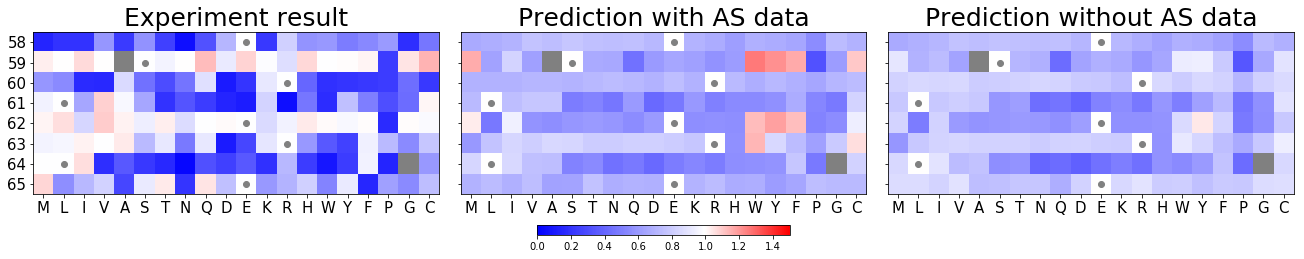

In [31]:
work_data = mut_prediction[mut_prediction['dmsa_id'] == 'urn:mavedb:00000012-a-5@gal4']
work_data = pd.merge(work_data, dms_ascan[['dmsa_id', 'position', 'aa2', 'pos_id', 'aa1', 'u_pos']], 
                     how='left', on=['dmsa_id', 'position', 'aa2'], suffixes=['', '_merge'])
# Data for S59A and L64G were explicitly added during predictor evaluation process.
fig = figs.prediction_heatmap(work_data)
plt.show()

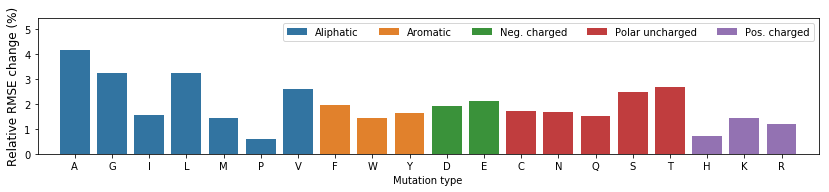

In [32]:
fig = figs.mutation_type_bias_barplot(mut_prediction)
plt.show()

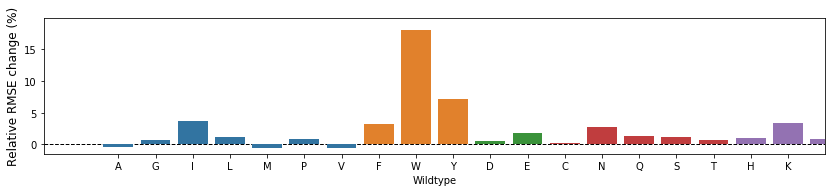

In [33]:
work_data = pd.merge(mut_prediction, dms_ascan[['dmsa_id', 'position', 'aa2', 'aa1']], 
                     how='left', on=['dmsa_id', 'position', 'aa2'], suffixes=['', '_merge'])
fig = figs.wildtype_bias_barplot(work_data)
plt.show()

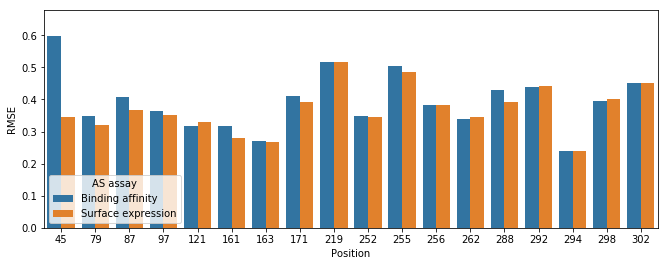

In [34]:
dms_as_pair = ['cxcr4-fitc-exp@cxcr4_tian_896', 'cxcr4-fitc-exp@cxcr4_tian_exp']
assay_info = dict(zip(dms_as_pair, ['Binding affinity', 'Surface expression']))
work_data = mut_prediction[mut_prediction['dmsa_id'].isin(dms_as_pair)]
work_data = pd.merge(work_data, dms_ascan[['dmsa_id', 'position', 'aa2', 'u_pos']], how='left', 
                     on=['dmsa_id', 'position', 'aa2'])
fig = figs.assay_error_barplot(work_data, dms_as_pair, assay_info)
plt.show()

## Feature importance

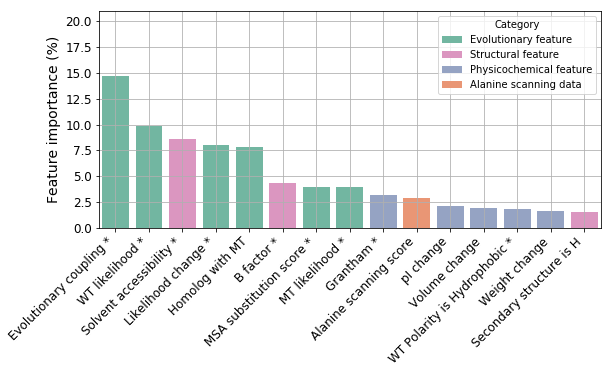

In [35]:
mean_importance = importance_with_as.median().sort_values(ascending=False)
imp_vis = mean_importance.head(15).to_frame()
imp_vis.columns = ['AS_imp']
imp_vis['Category'] = imp_vis.index.map(feature_info['type'])
correlated_feat = ['Evolutionary coupling', 'MT likelihood', 'MSA substitution score', 'Solvent accessibility',
                   'B factor', 'Secondary structure is E', 'WT Polarity is Hydrophobic', 'Grantham',
                   'WT likelihood', 'Likelihood change']

imp_vis.index = [x+' *' if x in correlated_feat else x for x in imp_vis.index.map(feature_info['feature_name'])]

palette = {'Evolutionary feature': (0.4, 0.7607843137254902, 0.6470588235294118),
           'Alanine scanning data': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
           'Physicochemical feature': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
           'Structural feature': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)}

plt.figure(figsize=(9, 4))
g = sns.barplot(x=imp_vis.index, y=imp_vis['AS_imp']*100, hue=imp_vis['Category'], data=imp_vis, 
                dodge=False, palette=palette)
plt.xticks(ticks=np.arange(15), labels=imp_vis.index, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.ylabel('Feature importance (%)', fontsize=14)
plt.ylim(0,21)
plt.show()

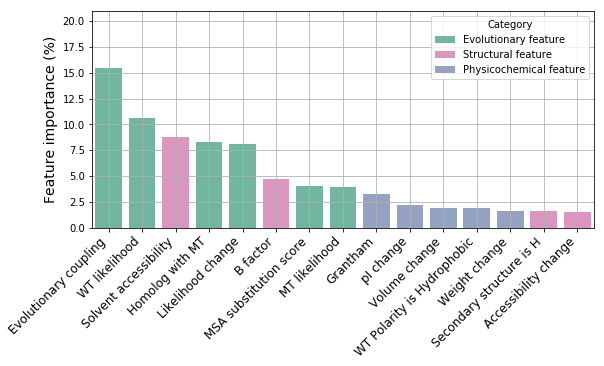

In [36]:
mean_importance = importance_without_as.median().sort_values(ascending=False)
imp_vis = mean_importance.head(15).to_frame()
imp_vis.columns = ['AS_imp']
imp_vis['Category'] = imp_vis.index.map(feature_info['type'])
imp_vis.index = imp_vis.index.map(feature_info['feature_name'])

palette = {'Evolutionary feature': (0.4, 0.7607843137254902, 0.6470588235294118),
           'Alanine scanning data': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
           'Physicochemical feature': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
           'Structural feature': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)}

plt.figure(figsize=(9,4))
g = sns.barplot(imp_vis.index, imp_vis['AS_imp']*100, imp_vis['Category'], data=imp_vis, 
                dodge=False, palette=palette)
plt.xticks(ticks=np.arange(15), labels=imp_vis.index, rotation=45, ha='right', fontsize=12)
plt.ylabel('Feature importance (%)', fontsize=14)
plt.ylim(0,21)
plt.grid()
plt.show()

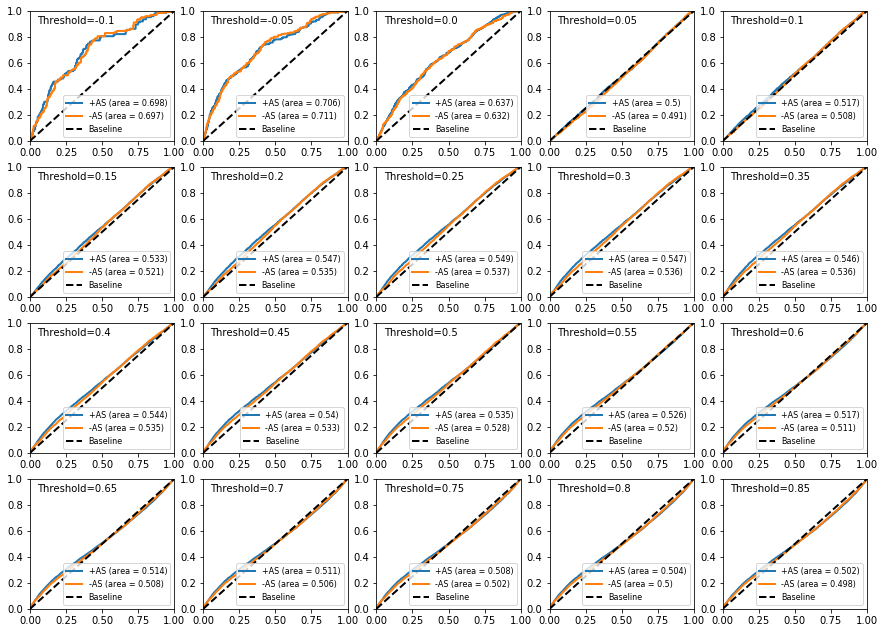

In [37]:
fig, axs = plt.subplots(4, 5, figsize=(15, 11))
axs = axs.reshape(-1)
for i, threshold in enumerate(np.arange(-0.1, 0.9, 0.05)):
    threshold = np.round(threshold, 2)
    if_not_loss = mut_prediction['ob_score'] <= threshold
    figs.plot_roc_curve_on_axes(axs[i], ['+AS', '-AS'], 
                                [if_not_loss, -mut_prediction['pred_score_ala']], 
                                [if_not_loss, -mut_prediction['pred_score_noala']])
    axs[i].text(0.05, 0.9, f"Threshold={threshold}")
    axs[i].legend(loc="lower right", fontsize=8)
plt.show()

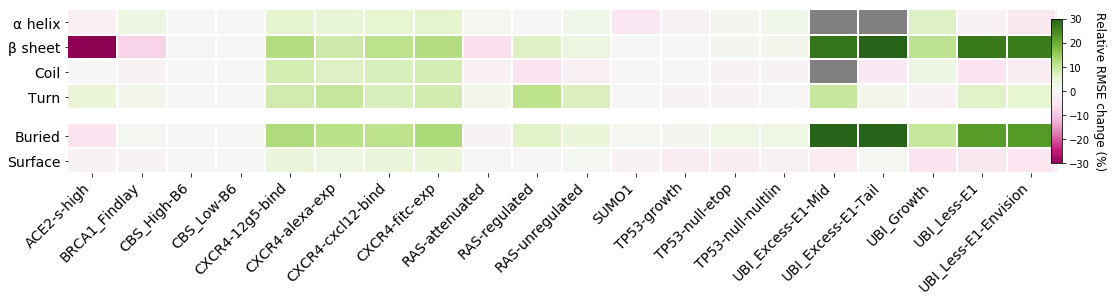

In [38]:
structure_data = dms_feature_data.loc[:, ['dms_id', 'position', 'aa1', 'dssp_sec_str', 'accessibility']]
structure_data['is_surface'] = structure_data['accessibility'] > 0.2
fig = figs.protein_structure_bias_heatmap(structure_data, mut_prediction, (-30, 30))
plt.show()